In [2]:
%load_ext autoreload
%autoreload 2
from models.base_model import SIRModelWrapper
from torchmetrics import MultioutputWrapper, R2Score, MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError 
import matplotlib.pyplot as plt
from data.epidemiology import generate_sir_from_state
import torch
plt.style.use("seaborn-v0_8-whitegrid")
from pathlib import Path
import os
ROOT_DIR = str(Path().resolve().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
N = 120
lag_size = 1
s0, i0, r0 = 0.99, 0.01, 0.

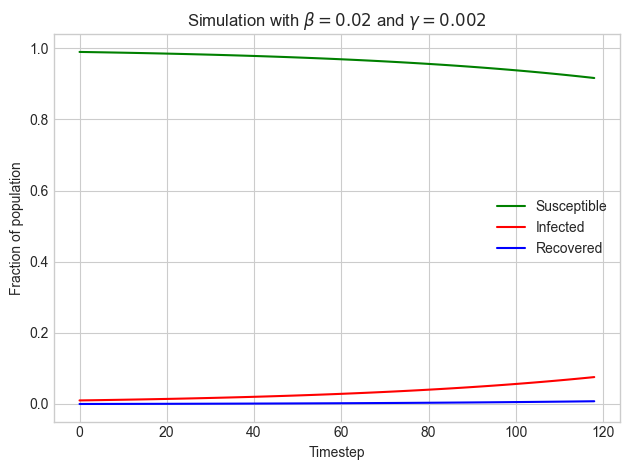

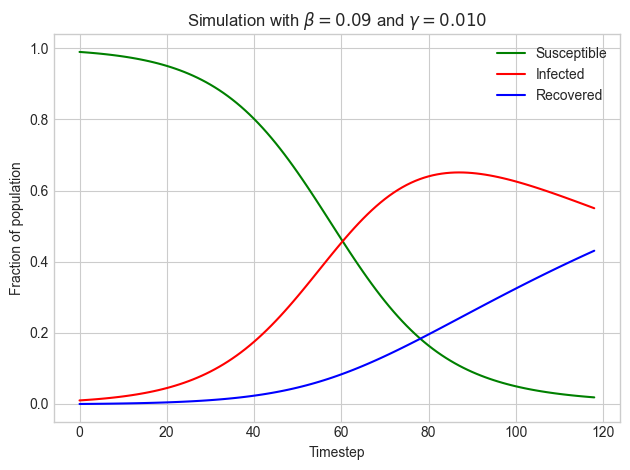

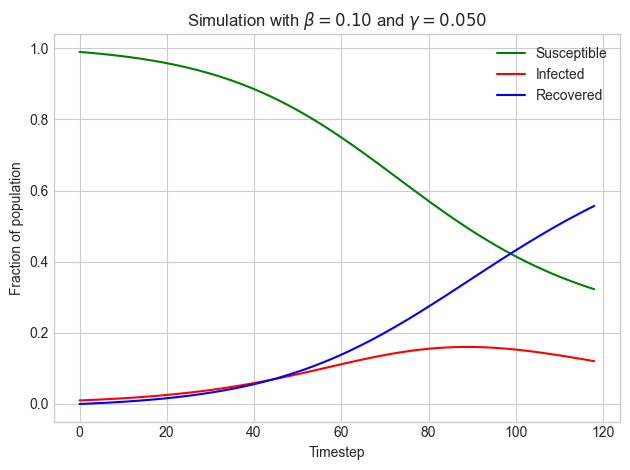

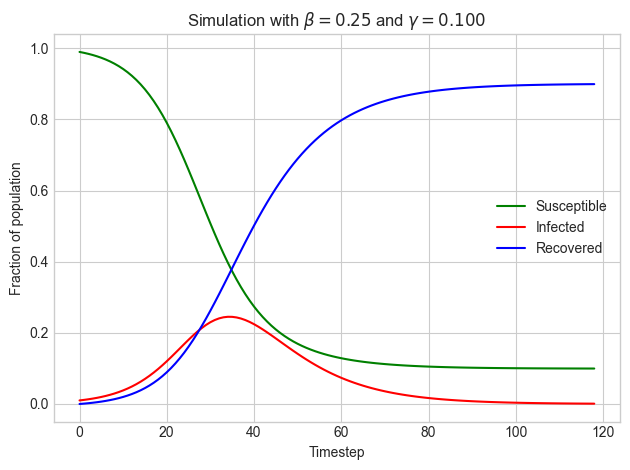

In [9]:
from data.epidemiology import generate_sir_from_state
beta = [0.02, 0.09, 0.1, 0.25]
gamma = [0.002, 0.01, 0.05, 0.1]
for i in range(len(beta)):
    fig, ax = plt.subplots()
    y = generate_sir_from_state(s0, i0, r0, beta[i], gamma[i], N, lag_size)
    ax.plot(y[:,0], color="green", label="Susceptible")
    ax.plot(y[:,1], color="red", label="Infected")
    ax.plot(y[:,2], color="blue", label="Recovered")
    ax.legend()
    ax.set_ylabel("Fraction of population")
    ax.set_xlabel("Timestep")
    ax.set_title(r"Simulation with $\beta=%.2f$ and $\gamma=%.3f$" % (beta[i], gamma[i]))
    fig.tight_layout()
    fig.savefig(os.path.join(ROOT_DIR,"report\\sir_simulation\\%.2ebeta_%.2egamma.png" % (beta[i], gamma[i])), bbox_inches="tight")

# Model eval

In [10]:
checkpoint = r"tb_logs\Epidemiology\120len_1lag\PDC\version_0\checkpoints\epoch=99-step=6400.ckpt"
model = SIRModelWrapper.load_from_checkpoint(checkpoint)

In [11]:
from utils.model_utils import count_parameters
count_parameters(model)

44547

In [ ]:
r2 = MultioutputWrapper(R2Score(), num_outputs=3)
mae = MultioutputWrapper(MeanAbsoluteError(), num_outputs=3)
mape = MultioutputWrapper(MeanAbsolutePercentageError(), num_outputs=3)
mse = MultioutputWrapper(MeanSquaredError(), num_outputs=3)

R2: [tensor(0.6109), tensor(0.8200), tensor(0.9544)]
MAE: [tensor(0.0150), tensor(0.0261), tensor(0.0179)]
MAPE: [tensor(3.8417), tensor(0.0440), tensor(0.0564)]
MSE: [tensor(0.0003), tensor(0.0008), tensor(0.0004)]


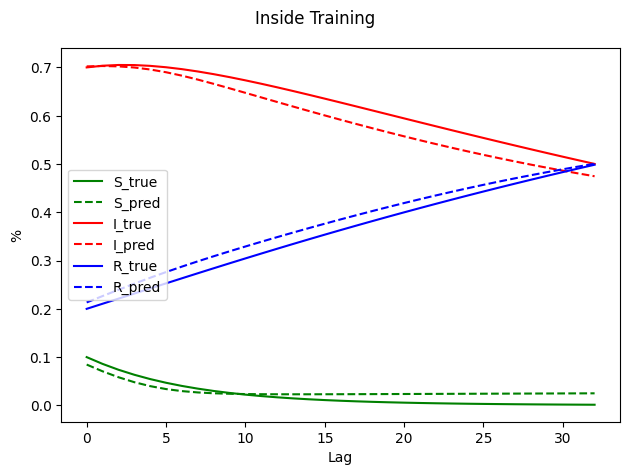

In [9]:

beta = 0.07
gamma = 0.005
y = generate_sir_from_state(s0, i0, r0, beta, gamma, N, lag_size)
preds = model.generate_sequence(N//lag_size, torch.Tensor([s0, i0, r0]), beta, gamma)

# Metrics
print("R2:", r2(preds, y))
print("MAE:", mae(preds, y))
print("MAPE:", mape(preds, y))
print("MSE:", mse(preds, y))

# Plot
fig, ax = plt.subplots()
ax.plot(y[:,0], color="green", label="S_true")
ax.plot(preds[:,0], color="green", linestyle="--", label="S_pred")
ax.plot(y[:,1], color="red", label="I_true")
ax.plot(preds[:,1], color="red", linestyle="--", label="I_pred")
ax.plot(y[:,2], color="blue", label="R_true")
ax.plot(preds[:,2], color="blue", linestyle="--", label="R_pred")
ax.legend()
ax.set_ylabel("%")
ax.set_xlabel("Lag")
fig.suptitle("Inside Training")
fig.tight_layout()

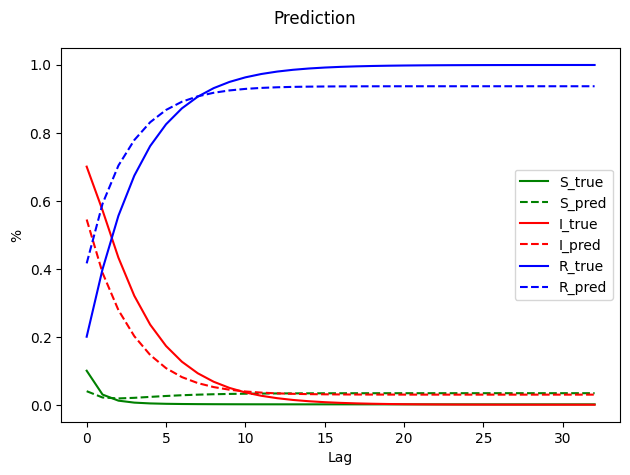

In [10]:
beta = 0.5
gamma = 0.1
y = generate_sir_from_state(s0, i0, r0, beta, gamma, N, lag_size)
preds = model.generate_sequence(N//lag_size, torch.Tensor([s0, i0, r0]), beta, gamma)
y_target = y
y_preds = preds.squeeze(0)

fig, ax = plt.subplots()
ax.plot(y[:,0], color="green", label="S_true")
ax.plot(preds[:,0], color="green", linestyle="--", label="S_pred")
ax.plot(y[:,1], color="red", label="I_true")
ax.plot(preds[:,1], color="red", linestyle="--", label="I_pred")
ax.plot(y[:,2], color="blue", label="R_true")
ax.plot(preds[:,2], color="blue", linestyle="--", label="R_pred")
ax.legend()
ax.set_ylabel("%")
ax.set_xlabel("Lag")
fig.suptitle("Prediction")
fig.tight_layout()